# Explore the linear model using ElasticNet 

## Data Processing

1. Drop attributes with missing values.
2. Drop categorical attributes.
3. Remove noise in training data, e.g lifeArea > allArea.

## Model Tuning

1. Tuned $\alpha$.
2. Tuned l1_ratio.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

dataDir = './data/'
# load original train/test data
#file_train = open(dataDir + 'train.dump', 'rb')
#file_test = open(dataDir + 'test.dump', 'rb')

#df_train = pickle.load(file_train)
#df_test = pickle.load(file_test)

file_train_wo = open(dataDir + 'train_without_noise.dump', 'rb')
df_train_wo = pickle.load(file_train_wo)
df_train = df_train_wo

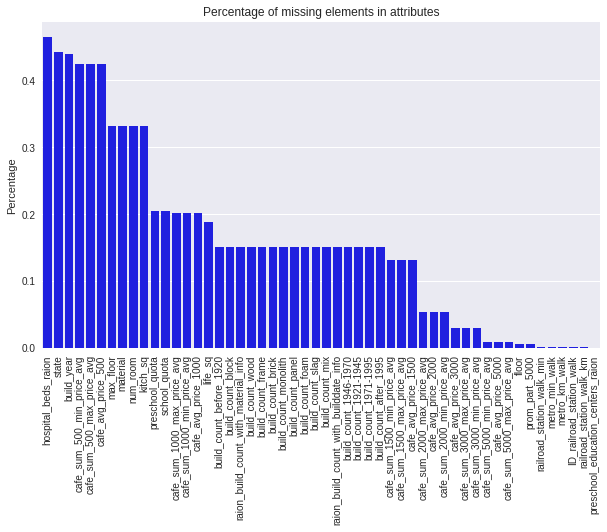

In [2]:
miss_cnt = df_train.apply(lambda x: sum(pd.isnull(x)))
miss_pct = miss_cnt / df_train.shape[0]
miss_pct = miss_pct[miss_pct > 0]

miss_pct_sort = miss_pct.sort_values(ascending=False)
miss_names = np.array(miss_pct_sort.index)

#plt.figure(figsize=(10, 6))
ax = sns.barplot(miss_names, miss_pct_sort, color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Percentage of missing elements in attributes')
plt.ylabel('Percentage');

In [3]:
print("Number of attributes with missing elements: {}".format(len(miss_names)))
col_dropped = list(miss_pct.index) + ['id', 'timestamp']
df_train.drop(col_dropped, axis=1, inplace=True)
print(df_train.columns)

Number of attributes with missing elements: 52
Index(['full_sq', 'product_type', 'sub_area', 'area_m', 'raion_popul',
       'green_zone_part', 'indust_part', 'children_preschool',
       'children_school', 'school_education_centers_raion',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=238)


Processing final test data.

In [4]:
file_test = open(dataDir + 'test.dump', 'rb')
df_test = pickle.load(file_test)
miss_test = df_test.apply(lambda x: sum(pd.isnull(x)))
miss_test = miss_test[miss_test > 0]
#print([item for item in miss_test.index if item not in miss_names], len(miss_test))
#print(df_test[['product_type', 'green_part_2000']].dtypes)

df_test_dropped = df_test.drop(col_dropped, axis=1)
#print(df_test.columns)
df_test_dropped.fillna(method='backfill', inplace=True)
X_te = df_test_dropped.select_dtypes(exclude=['object'])

In [5]:
y = df_train.price_doc
X = df_train.drop('price_doc', axis=1).select_dtypes(exclude=['object'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19359, 222) (9536, 222) (19359,) (9536,)


In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

def RMSLE(y_true, y_predict):
    return np.sqrt(mean_squared_error(np.log(y_true+1), np.log(np.maximum(y_predict, 0)+1)))

In [8]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

alphas = [0.01, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
error_train = []
error_test = []
for alpha in alphas:
    enet = ElasticNet(alpha=alpha, tol=0.1)#, normalize=True)
    enet.fit(X_train, y_train)
    #y_hat = np.maximum(enet.predict(X_train), 0)
    #sns.distplot(y_hat)
    error_train.append(RMSLE(y_train, enet.predict(X_train)))
    error_test.append(RMSLE(y_test, enet.predict(X_test)))
    
print(error_train, error_test)

/home/matthew/anaconda3/envs/sml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[0.79688073225670464, 0.79673508073639321, 0.78272513286574186, 0.71720485826101343, 0.82236894725540521, 0.56332227097116805, 0.6110825148108513, 0.6254997425697344] [0.88983914059123925, 0.88926453179101739, 0.82397882174447334, 0.7327888242200884, 0.83616980609856539, 0.55640981991244964, 0.62545960836615244, 0.63884442293524768]


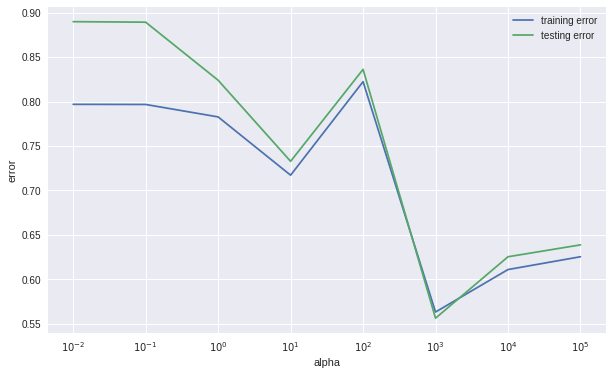

In [9]:
ax = plt.gca()
plt.plot(alphas, error_train, label='training error')
plt.plot(alphas, error_test, label='testing error')
plt.xlabel('alpha')
plt.ylabel('error')
ax.set_xscale('log')
plt.legend()

In [10]:
error_train = []
error_test = []

In [11]:
#alphas = [600, 800, 1000, 1200]
for alpha in alphas:
    enet = ElasticNet(alpha=alpha, tol=0.1, normalize=True)
    enet.fit(X_train, y_train)

    error_train.append(RMSLE(y_train, enet.predict(X_train)))
    error_test.append(RMSLE(y_test, enet.predict(X_test)))

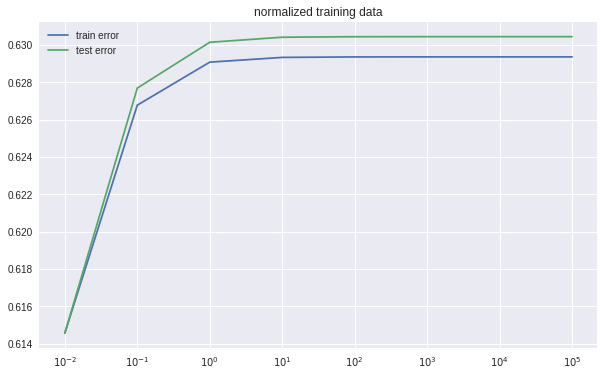

In [12]:
ax = plt.gca()
plt.plot(alphas, error_train, label='train error')
plt.plot(alphas, error_test, label='test error')
ax.set_xscale('log')
plt.title('normalized training data')
plt.legend()

/home/matthew/anaconda3/envs/sml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


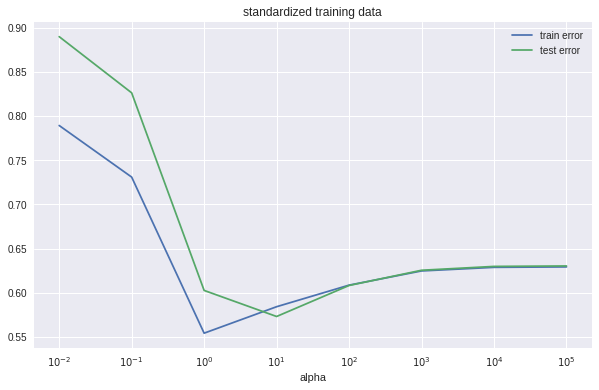

In [13]:
from sklearn.preprocessing import StandardScaler

error_train = []
error_test = []

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for alpha in alphas:
    enet = ElasticNet(alpha=alpha, tol=0.1, normalize=False)
    enet.fit(X_train, y_train)

    error_train.append(RMSLE(y_train, enet.predict(X_train)))
    error_test.append(RMSLE(y_test, enet.predict(X_test)))

ax = plt.gca()
plt.plot(alphas, error_train, label='train error')
plt.plot(alphas, error_test, label='test error')
ax.set_xscale('log')
plt.xlabel('alpha')
plt.title('standardized training data')
plt.legend()

/home/matthew/anaconda3/envs/sml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


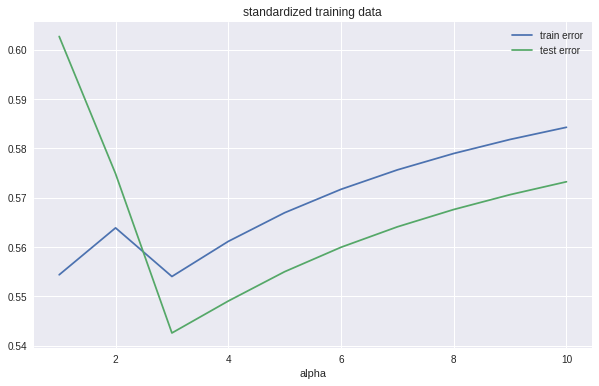

In [14]:
error_train = []
error_test = []
alphas = list(range(1, 11))

for alpha in alphas:
    enet = ElasticNet(alpha=alpha, tol=0.1, normalize=False)
    enet.fit(X_train, y_train)

    error_train.append(RMSLE(y_train, enet.predict(X_train)))
    error_test.append(RMSLE(y_test, enet.predict(X_test)))

ax = plt.gca()
plt.plot(alphas, error_train, label='train error')
plt.plot(alphas, error_test, label='test error')
plt.xlabel('alpha')
plt.title('standardized training data')
plt.legend()

/home/matthew/anaconda3/envs/sml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/matthew/anaconda3/envs/sml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


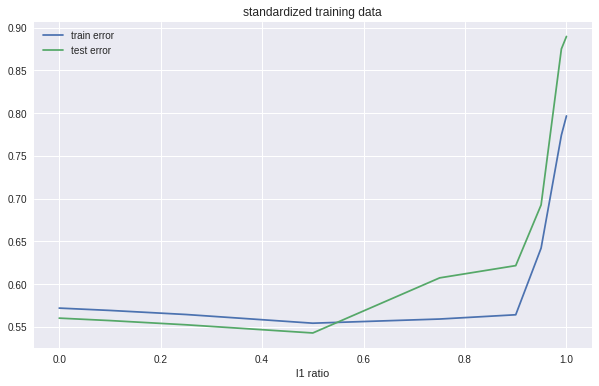

In [15]:
error_train = []
error_test = []
ALPHA = 3

ratios = [0, .1, 0.25, 0.5, 0.75, .9, .95, .99, 1]
#[.1, .5, .7, .9, .95, .99, 1]

for ratio in ratios:
    enet = ElasticNet(alpha=ALPHA, l1_ratio=ratio, tol=0.1, normalize=False)
    enet.fit(X_train, y_train)

    error_train.append(RMSLE(y_train, enet.predict(X_train)))
    error_test.append(RMSLE(y_test, enet.predict(X_test)))
    
ax = plt.gca()
plt.plot(ratios, error_train, label='train error')
plt.plot(ratios, error_test, label='test error')
plt.xlabel('l1 ratio')
plt.title('standardized training data')
plt.legend()

For ElasticNet model, the alpha is set to 3 and l1_ratio is set to 0.5.

In [16]:
enet = ElasticNet(alpha=3)
X_tr = scaler.fit_transform(X)
Xtest = scaler.transform(X_te)

enet.fit(X_tr, y)
y_pred = enet.predict(Xtest)

/home/matthew/anaconda3/envs/sml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [20]:
y_pred = np.maximum(y_pred, 0)

In [21]:
y_output = df_test['id']
y_output = pd.concat([y_output, pd.Series(list(np.round(y_pred, 2)), name='price_doc')], axis=1)
#y_output[:10]
with open(dataDir + 'test_submission_elastic_alpha3.csv', 'w') as fw:
    y_output.to_csv(path_or_buf=fw, index=False)

In [22]:
y_output[y_output['price_doc'] <= 0]

,id,price_doc
935,31409,0.0
